## Here we import necessary libraries

In [6]:
import pandas as pd
import cv2
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import tensorflow.keras as tf
import glob
from sklearn.metrics import accuracy_score

This function reads either all images as operation='all' or specific bash format of the image names like operation = 'bla\*\_bacteria_*'. sizeh and sizew are the desired resized value of height and width of images  


In [7]:
def imreadandresffold(path, fileextension, sizeh, sizew, operation):
  if operation is 'all':
    imdata= np.stack([cv2.resize(cv2.imread(file)/np.max(cv2.imread(file)), (sizeh,sizew), interpolation = cv2.INTER_NEAREST) for file in glob.glob(path + '*.' + fileextension)])
  else:
    imdata= np.stack([cv2.resize(cv2.imread(file)/np.max(cv2.imread(file)), (sizeh,sizew), interpolation = cv2.INTER_NEAREST) for file in glob.glob(path + operation + '.' + fileextension)])
  return imdata

specification of paths, which are from my colab directories. You can find the use of function here

In [8]:

path = 'Your path to NORMAL folder'
pathpne = 'Your path to PNEUMONIA folder'
imdatanorm = imreadandresffold(path, 'jpeg', 128, 128, 'all')
imdatapne_bac = imreadandresffold(pathpne, 'jpeg', 128, 128, 'person*_bacteria_*')
imdatapne_vir = imreadandresffold(pathpne, 'jpeg', 128, 128, 'person*_virus_*')

In [ ]:
imdatapne_vir.shape

(1345, 128, 128, 3)

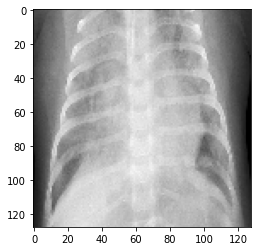

In [ ]:
plt.imshow(imdatapne_vir[0,...])

Here we concataneta all images we read from above and we create label variable depending on their properties like normal or pneuomina with bacteria or virus

In [9]:
trainingdata = np.concatenate([imdatanorm, imdatapne_bac, imdatapne_vir])
label = np.zeros((trainingdata.shape[0],3))
label[0:imdatanorm.shape[0],0] = 1
label[imdatanorm.shape[0]:(imdatanorm.shape[0]+imdatapne_bac.shape[0]),1] = 1
label[(imdatanorm.shape[0]+imdatapne_bac.shape[0]):trainingdata.shape[0],2] = 1

Here we shuffle all the trainingdata and label exactly in the same way 

In [10]:
indexes = np.arange(trainingdata.shape[0])
np.random.shuffle(indexes)
trainindatashuff = trainingdata[indexes,...]
labelshuff = label[indexes]
labelshuff = labelshuff.astype(int)

Our Deep Learning Architecture part, you can change it or add your own design. 

In [11]:
input_layer = tf.Input(shape=(128, 128, 3))

x = tf.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(input_layer)
#x = tf.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = tf.layers.MaxPool2D((2, 2), padding='same', strides=(1, 1))(x)
x = tf.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
#x = tf.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = tf.layers.MaxPool2D((2, 2), padding='same', strides=(1, 1))(x)
x = tf.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = tf.layers.MaxPool2D((2, 2), padding='same', strides=(1, 1))(x)
#x = tf.layers.Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
#x = tf.layers.MaxPool2D((2, 2), padding='same', strides=(1, 1))(x)
#x = tf.layers.Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
#x = tf.layers.Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
#x = tf.layers.MaxPool2D((2, 2), padding='same', strides=(1, 1))(x)
#x = tf.layers.Lambda(lambda x: x**2)(x)
x = tf.layers.Flatten()(x)
x = tf.layers.Dense(128, activation='relu')(x)
x = tf.layers.Dense(128, activation='relu')(x)
x = tf.layers.Dense(3)(x)


In [ ]:
initial_learning_rate = 0.01
lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.96,
    staircase=True)

model = tf.Model(input_layer, x)
#losse = tf.losses.mse()
model.compile(loss='mse', optimizer=tf.optimizers.Adam())
model.fit(trainindatashuff[0:1000,...], labelshuff[0:1000,...], batch_size=50, epochs=50)

Epoch 1/50
 8/20 [===========>..................] - ETA: 2:22 - loss: 0.1786

In [13]:
veri = trainindatashuff[1000:2500,...]
veri = veri.reshape(1500,128,128,3)
predictions = model.predict(veri)

In [14]:
accuracy_score(np.argmax(predictions,axis=1),np.argmax(labelshuff[1000:2500,...],axis=1))

0.718